# Sarcasm Detection

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
import joblib
from collections import Counter
from wordcloud import WordCloud
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer,ENGLISH_STOP_WORDS
from sklearn.manifold import TSNE

import src.data_processing as data_processing 
import src.utils as utils

This notebook only presents the visualization part of our project.  
You can find all the code, report, and slides at the following link:  

[GitHub Repository](https://github.com/Lynchrocket/Sarcasm-Detection_HoNLP.git)

In [ ]:
import webbrowser
# GitHub link
github_url = "https://github.com/Lynchrocket/Sarcasm-Detection_HoNLP.git"
webbrowser.open(github_url)

True

In [2]:
train_cleaned, train_labels, test_cleaned, test_labels = data_processing.get_clean_data(
    "data/datasets/ghosh/train.txt",
    "data/datasets/ghosh/test.txt"
)

Our data is balanced

In [3]:
train_df = pd.DataFrame({
    'Text': train_cleaned,
    'Label': train_labels
})

test_df = pd.DataFrame({
    "Text": test_cleaned,
    "Label": test_labels
})

In [6]:
train_df

,Text,Label
0,It feel like just a few day ago it be the last...,1
1,"I love my mom . No matter what we go through ,...",1
2,Bump that music ... i be try to sleep,1
3,Mexican and black joke be pretty much the same...,0
4,How to find work you love :,0
...,...,...
51184,RT My EX have one very annoy habit . Breathe .,1
51185,"Some day you be the Titanic , some day you be ...",1
51186,"Congrats on the release of 25 @user , let u ho...",0
51187,do my favorite thing .. cry,1


In [7]:
test_df

,Text,Label
0,It feel like just a few day ago it be the last...,1
1,"I love my mom . No matter what we go through ,...",1
2,Bump that music ... i be try to sleep,1
3,Mexican and black joke be pretty much the same...,0
4,How to find work you love :,0
...,...,...
51184,RT My EX have one very annoy habit . Breathe .,1
51185,"Some day you be the Titanic , some day you be ...",1
51186,"Congrats on the release of 25 @user , let u ho...",0
51187,do my favorite thing .. cry,1


In [8]:
def plot_pie_chart(labels, title):
    label_counts = [sum(labels == 0), sum(labels == 1)]
    label_names = ['Non-Sarcastic', 'Sarcastic']

    colors = ['#66b3ff', '#ff9999']  
    plt.figure(figsize=(8, 8), facecolor='white') 
    
    wedges, texts, autotexts = plt.pie(
        label_counts,
        labels=label_names,
        colors=colors,
        autopct='%1.1f%%',
        startangle=90,
        textprops={'fontsize': 12, 'color': 'black'},  
    )
    
    plt.title(title, fontsize=15, pad=20)
    plt.axis('equal')  
    
    for autotext in autotexts:
        autotext.set_fontsize(12)
        autotext.set_color('white')  
    
    plt.tight_layout()  
    plt.show()

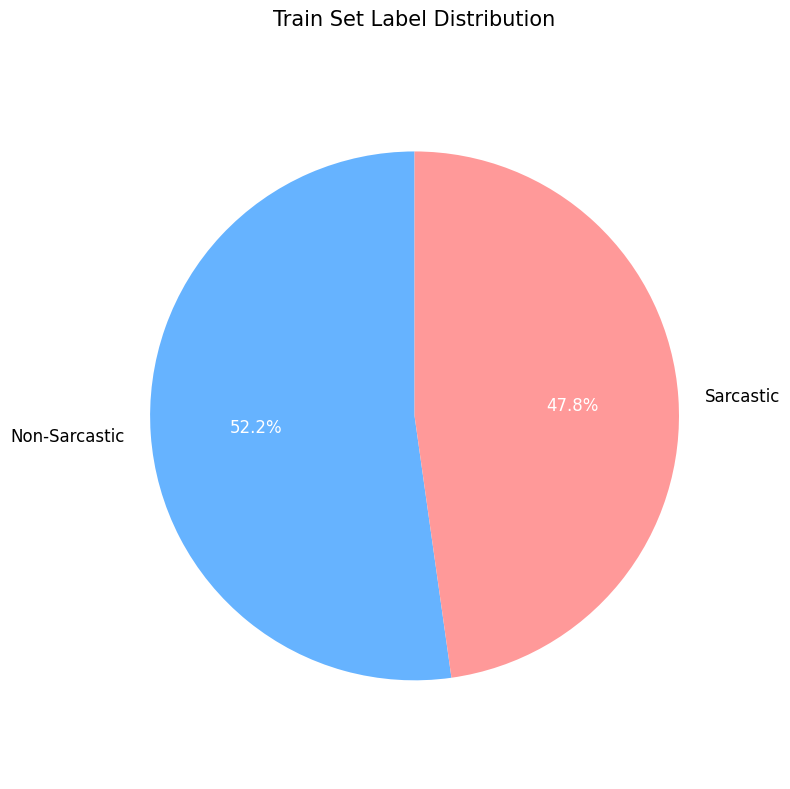

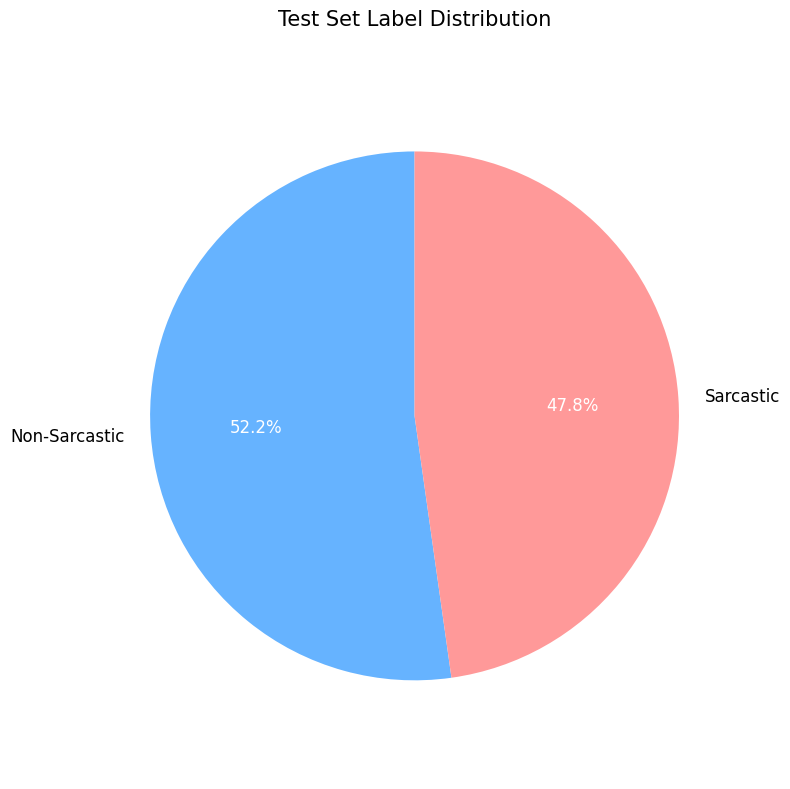

In [9]:
plot_pie_chart(train_df['Label'], 'Train Set Label Distribution')
plot_pie_chart(test_df['Label'], 'Test Set Label Distribution')

Show 20 High Frequency Words With Stop Words

In [10]:
sarcastic_df = train_df[train_df['Label'] == 1]
non_sarcastic_df = train_df[train_df['Label'] == 0]

In [11]:
def get_word_counts(df):
    words = df['Text'].apply(lambda x: x.split()).explode().tolist()
    word_counts = Counter(words).most_common(20)
    return word_counts

In [12]:

def get_all_counts(df):
    words = df['Text'].apply(lambda x: x.split()).explode().tolist()
    total_words = len(words)
    return total_words

In [13]:
def plot_bar_chart_with_median(word_counts, label_type):
    plt.figure(figsize=(12, 8))
    
    words, counts = zip(*word_counts)
    
    cmap = plt.cm.get_cmap('coolwarm', len(counts))  
    norm = plt.Normalize(vmin=min(counts), vmax=max(counts))  

    bars = plt.barh(words, counts, color=cmap(norm(counts)), edgecolor='black', height=0.8, zorder=3)
    
    median_value = np.median(counts)
    
    plt.axvline(median_value, color='red', linestyle='--', linewidth=2, label=f'Median: {median_value}')
    
    plt.gca().invert_yaxis()
    plt.title(f'Top 20 {label_type} Words',fontsize=18)
    plt.xlabel('Frequency',fontsize=14)
    plt.ylabel('Words',fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

    plt.legend(loc='upper right', fontsize=12, facecolor='white')
    plt.tight_layout()
    plt.show()

In [14]:
def plot_word_cloud(word_counts, label_type):
    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='white'
    ).generate_from_frequencies(dict(word_counts))
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.title(f'{label_type} Word Cloud')
    plt.show()

In [15]:
sarcastic_word_counts_all = get_all_counts(sarcastic_df)
non_sarcastic_word_counts_all = get_all_counts(non_sarcastic_df)
sarcastic_word_counts_all
non_sarcastic_word_counts_all

477726

C:\Users\Lynch\AppData\Local\Temp\ipykernel_32908\162409676.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('coolwarm', len(counts))


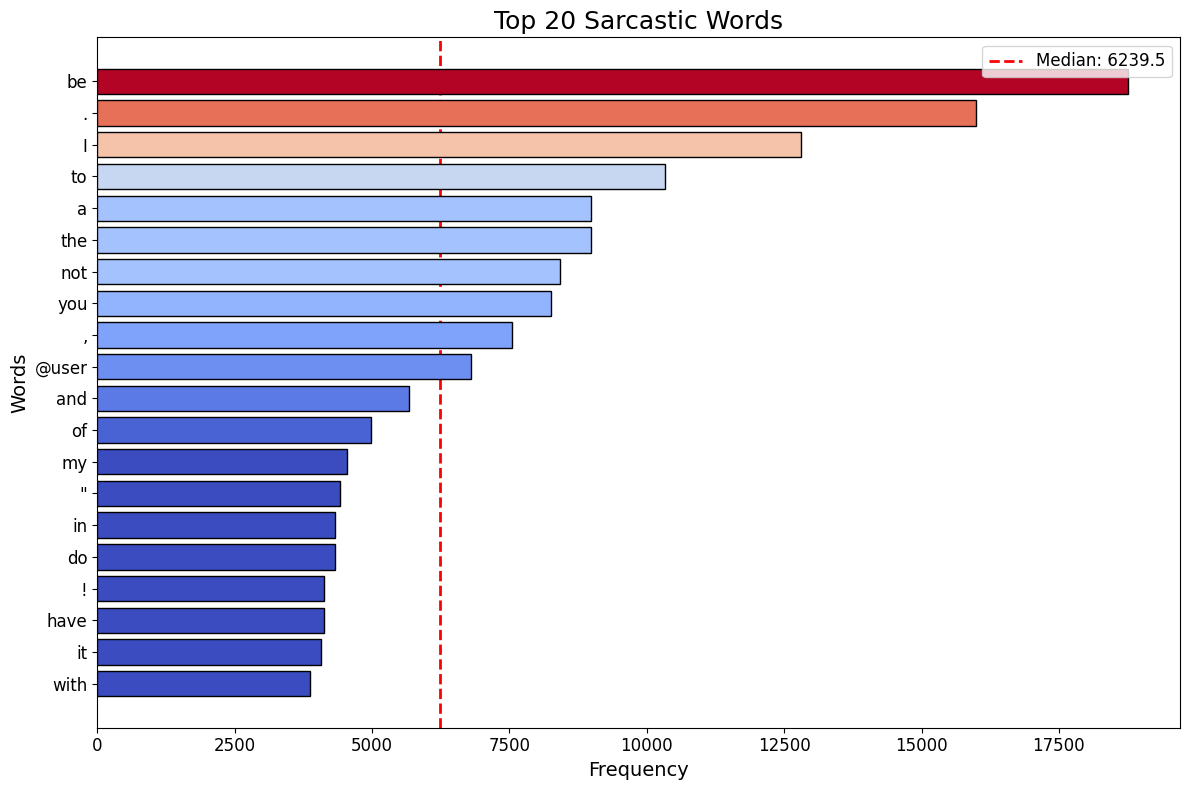

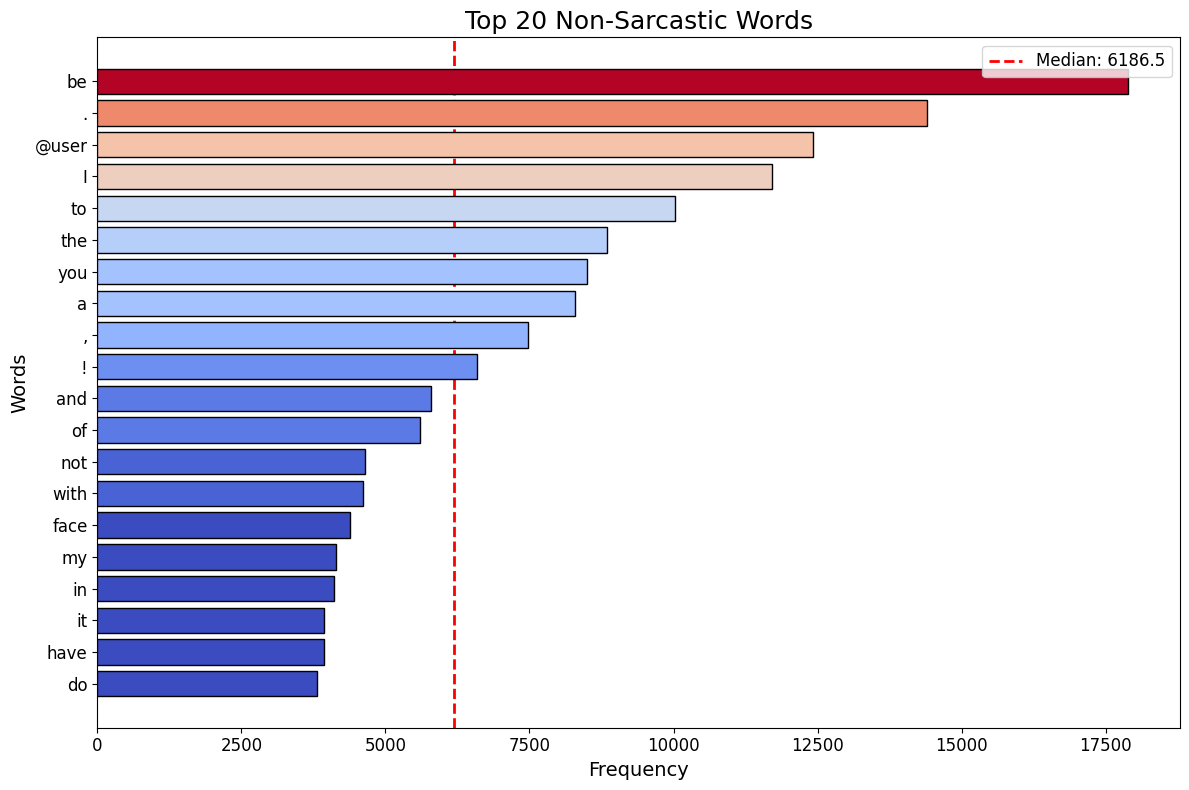

In [16]:
sarcastic_word_counts = get_word_counts(sarcastic_df)
non_sarcastic_word_counts = get_word_counts(non_sarcastic_df)

plot_bar_chart_with_median(sarcastic_word_counts, 'Sarcastic') 
plot_bar_chart_with_median(non_sarcastic_word_counts, 'Non-Sarcastic')  

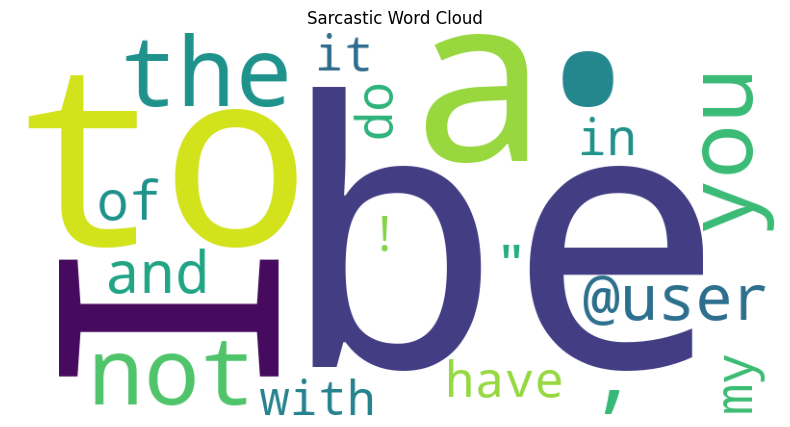

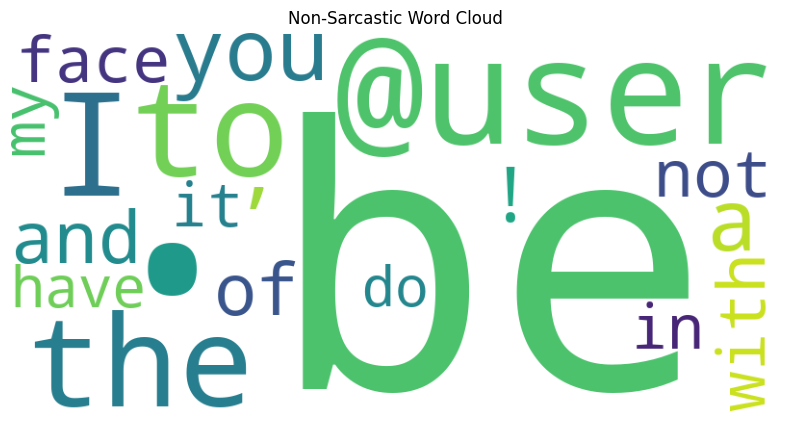

In [17]:
plot_word_cloud(sarcastic_word_counts, 'Sarcastic')
plot_word_cloud(non_sarcastic_word_counts, 'Non-Sarcastic')

In [18]:
def plot_combined_word_cloud(sarcastic_word_counts, non_sarcastic_word_counts):
    sarcastic_wc = WordCloud(
        width=800,
        height=400,
        background_color='white',
        colormap='Reds',  
        max_words=100
    ).generate_from_frequencies(dict(sarcastic_word_counts))

    non_sarcastic_wc = WordCloud(
        width=800,
        height=400,
        background_color='white',
        colormap='Blues',  
        max_words=100
    ).generate_from_frequencies(dict(non_sarcastic_word_counts))

    plt.figure(figsize=(15, 8))

    plt.subplot(1, 2, 1)
    plt.imshow(sarcastic_wc, interpolation='bilinear')
    plt.axis('off')
    plt.title('Sarcastic Word Cloud', fontsize=16)

    plt.subplot(1, 2, 2)
    plt.imshow(non_sarcastic_wc, interpolation='bilinear')
    plt.axis('off')
    plt.title('Non-Sarcastic Word Cloud', fontsize=16)

    plt.tight_layout()
    plt.show()

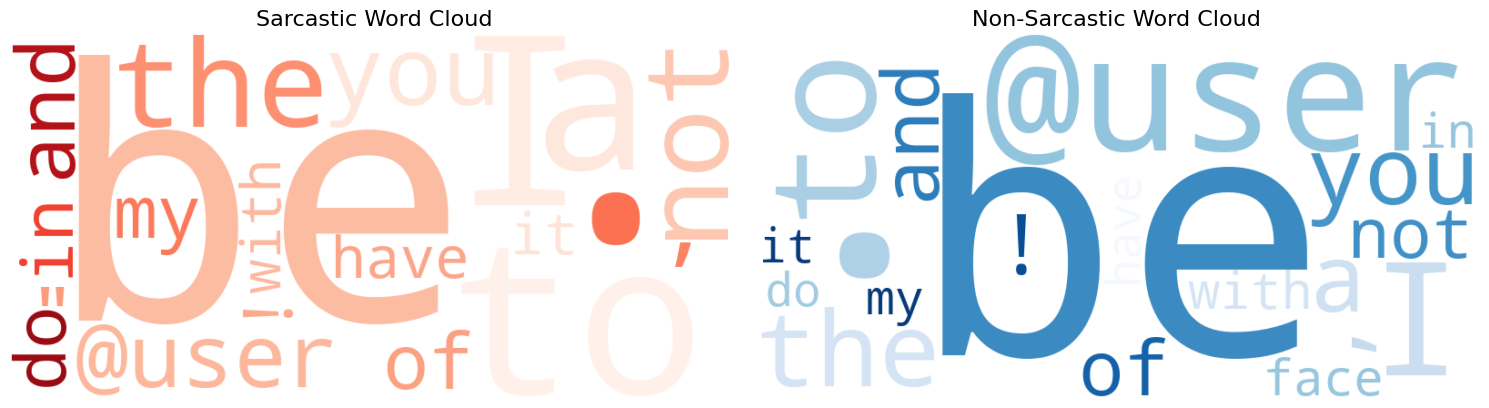

In [19]:
plot_combined_word_cloud(sarcastic_word_counts, non_sarcastic_word_counts)

Show 20 High Frequency Words Without Stop Words

In [20]:
def get_word_counts_no_stopwords(df):
    custom_stopwords = list(ENGLISH_STOP_WORDS) + ["user"]
    vectorizer = CountVectorizer(stop_words=custom_stopwords)
    count_matrix = vectorizer.fit_transform(df['Text'])
    word_counts = np.asarray(count_matrix.sum(axis=0)).flatten()
    words = vectorizer.get_feature_names_out()
    top_words = sorted(zip(words, word_counts), key=lambda x: -x[1])[:20]
    return top_words

C:\Users\Lynch\AppData\Local\Temp\ipykernel_32908\162409676.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('coolwarm', len(counts))


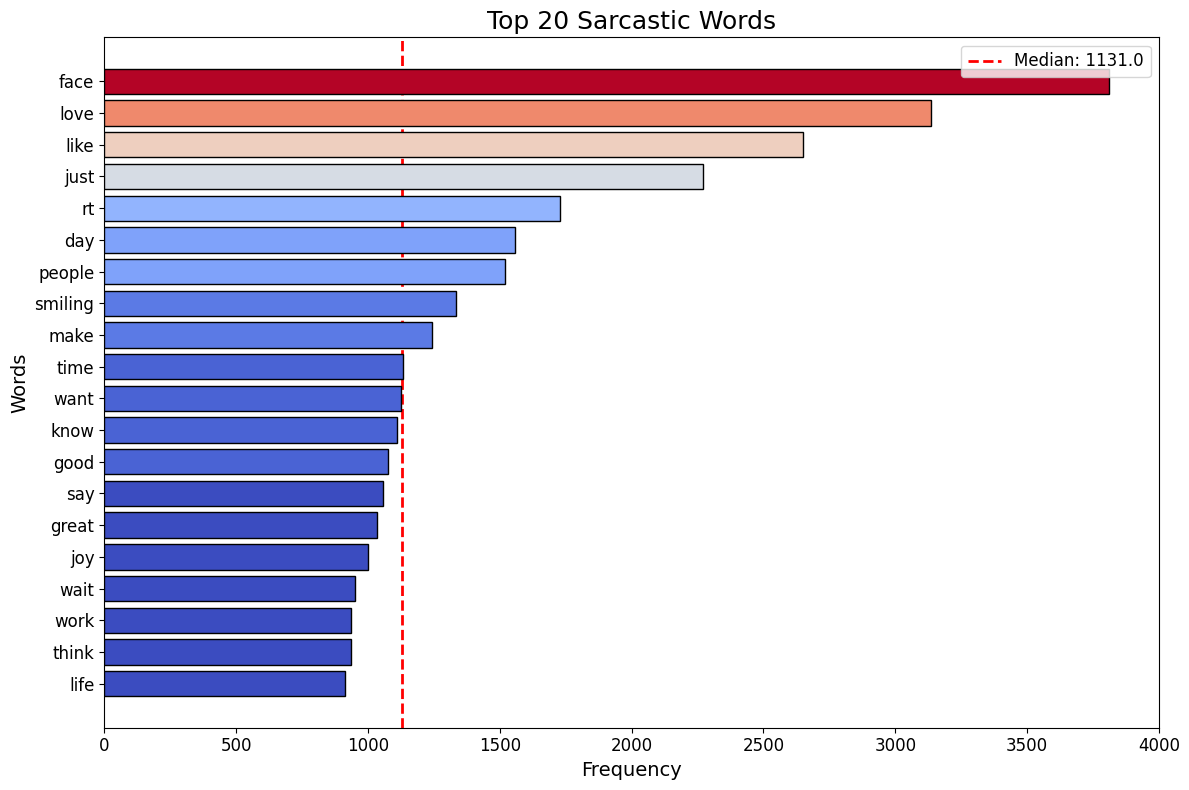

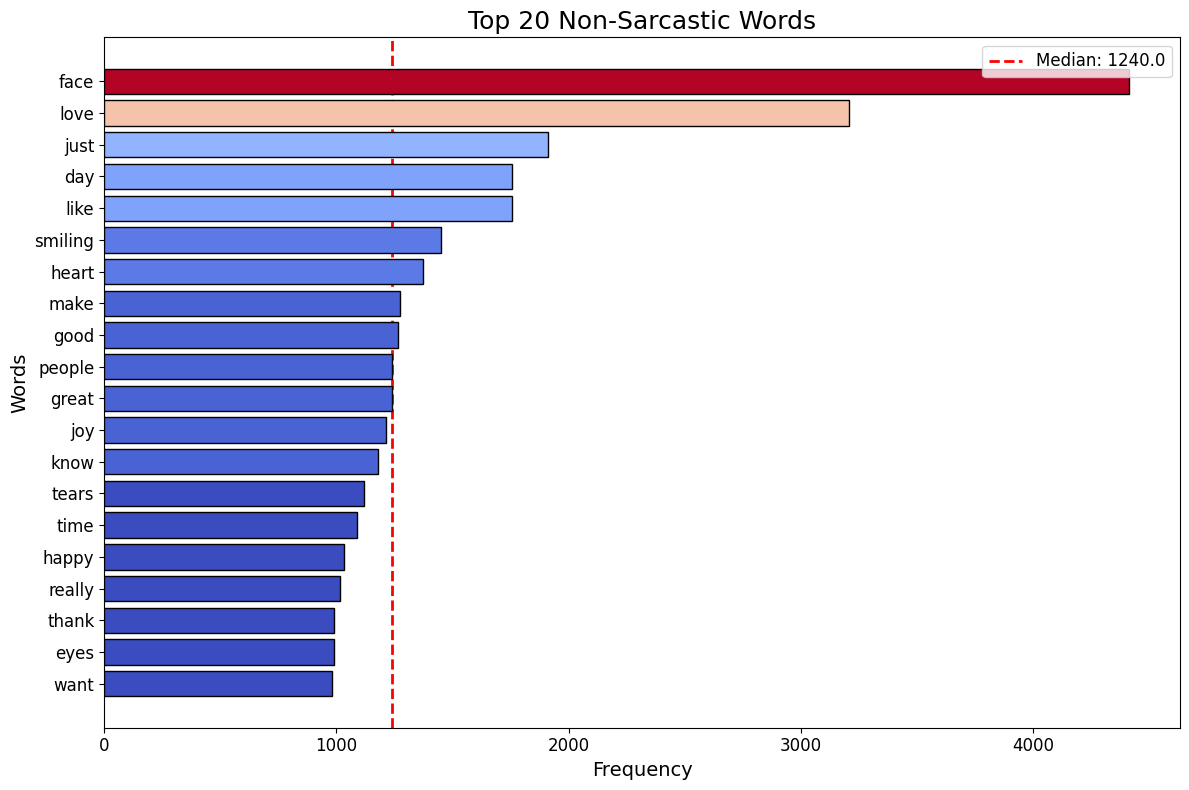

In [21]:
sarcastic_word_counts_no_stopwords= get_word_counts_no_stopwords(sarcastic_df)
non_sarcastic_word_counts_no_stopwords = get_word_counts_no_stopwords(non_sarcastic_df)

plot_bar_chart_with_median(sarcastic_word_counts_no_stopwords, 'Sarcastic') 
plot_bar_chart_with_median(non_sarcastic_word_counts_no_stopwords, 'Non-Sarcastic')  

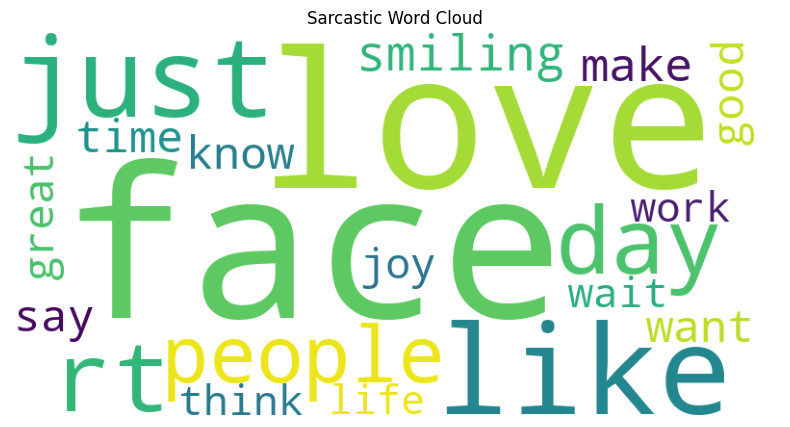

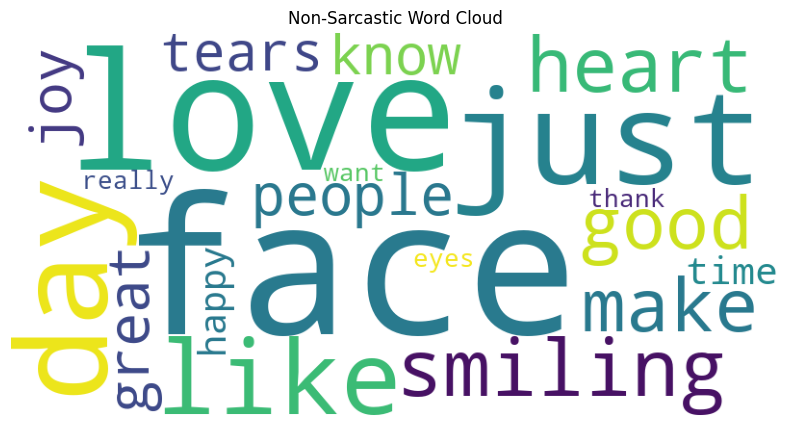

In [22]:
plot_word_cloud(sarcastic_word_counts_no_stopwords, 'Sarcastic')
plot_word_cloud(non_sarcastic_word_counts_no_stopwords, 'Non-Sarcastic')

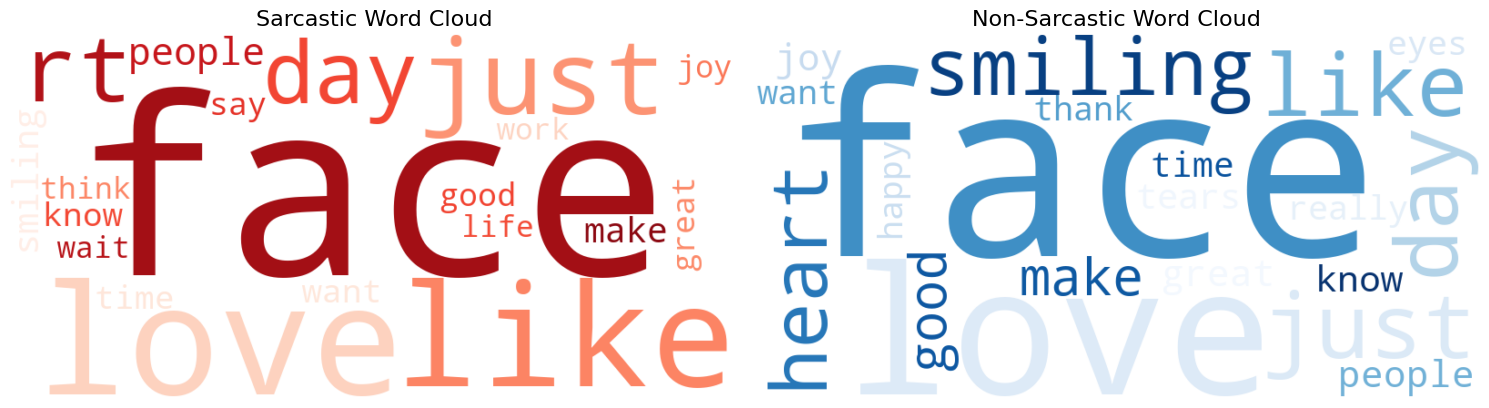

In [23]:
plot_combined_word_cloud(sarcastic_word_counts_no_stopwords, non_sarcastic_word_counts_no_stopwords)

## Vectorization and model testing:

SVM model with TD-IDF

In [5]:
svm_model_file = './model/model_svm.pkl'
svm_model = joblib.load(svm_model_file)

vectorizer = joblib.load('./model/tfidf.pkl')
test_x_svm = vectorizer.transform(train_df['Text']).toarray()

Deep Learning Model with Skip-gram and fasttext

In [4]:
word2vec_skipgram, word2int_skipgram = utils.get_word2vec_model(train_df["Text"].apply(lambda x: x.split()), model_type='skipgram')

In [ ]:
word2vec_fasttext, word2int_fasttext = utils.get_word2vec_model(train_df["Text"].apply(lambda x: x.split()), model_type='fasttext')

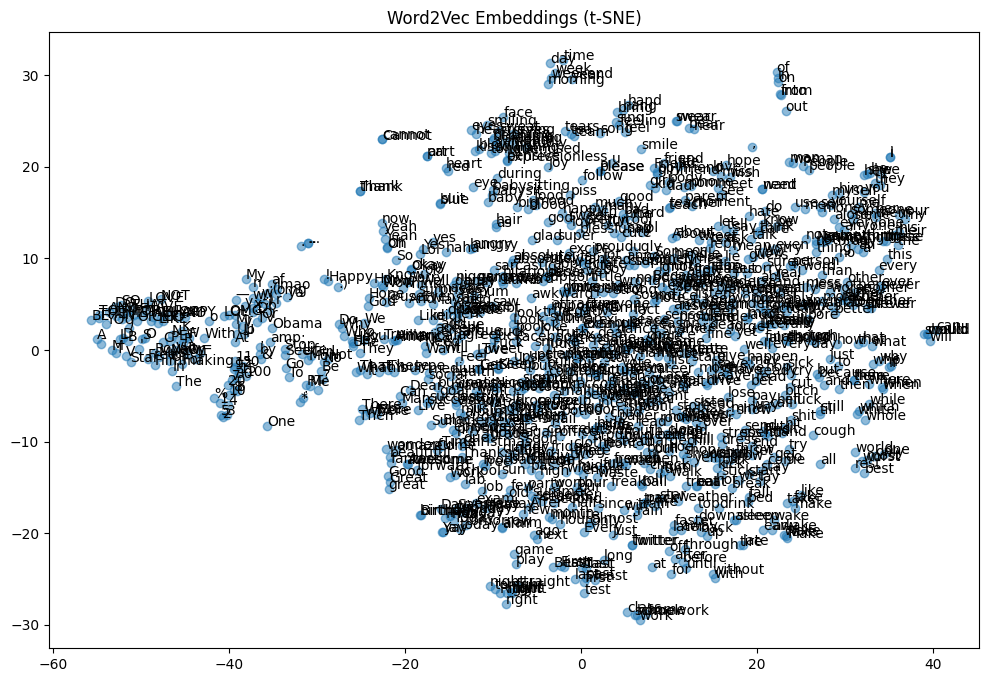

In [8]:
words = [word for word in list(word2int_fasttext.keys())[:1000] if word in word2vec_fasttext.wv]
vectors = np.array([word2vec_fasttext.wv[word] for word in words])  # transfer into (n_samples, n_features)

tsne = TSNE(n_components=2, random_state=42)
vectors_2d = tsne.fit_transform(vectors)

plt.figure(figsize=(12, 8))
plt.scatter(vectors_2d[:, 0], vectors_2d[:, 1], alpha=0.5)
for i, word in enumerate(words):
    plt.annotate(word, (vectors_2d[i, 0], vectors_2d[i, 1]))
plt.title("Word2Vec Embeddings (t-SNE)")
plt.show()

In [5]:
def load_model(file_path):
    model = torch.load(file_path, map_location=torch.device('cpu'), weights_only=False)
    model.eval()
    return model

In [6]:
def text_to_sequence(text, word2int, max_len):
    tokens = text.split()
    seq = [word2int.get(token, 0) for token in tokens]
    seq = seq[:max_len] if len(seq) > max_len else seq + [0] * (max_len - len(seq))
    return seq

In [7]:
max_len = utils.get_max_len(train_cleaned)

In [8]:
test_sequences = [text_to_sequence(text, word2int_skipgram, max_len) for text in test_df['Text']]
X_test_skipgram = torch.tensor(test_sequences, dtype=torch.long)

In [15]:
test_sequences = [text_to_sequence(text, word2int_fasttext, max_len) for text in test_df['Text']]
X_test_fasttext = torch.tensor(test_sequences, dtype=torch.long)

Prediction functions:

In [9]:
def predict(model, X_test_tensor):
    with torch.no_grad():
        outputs = model(X_test_tensor)
        return (outputs.squeeze() > 0.5).int().numpy()

In [10]:
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Non-Sarcasm", "Sarcasm"], 
                yticklabels=["Non-Sarcasm", "Sarcasm"])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(title)
    plt.show()

In [11]:
def show_classification_report(y_true, y_pred):
    print(classification_report(y_true, y_pred, target_names=["Non-Sarcastic", "Sarcastic"]))

### SVM prediction 

In [ ]:
svm_preds = svm_model.predict(test_x_svm)

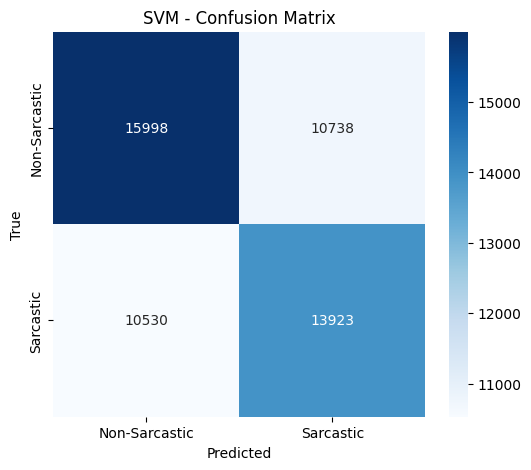

SVM - Classification Report:
               precision    recall  f1-score   support

Non-Sarcastic       0.60      0.60      0.60     26736
    Sarcastic       0.56      0.57      0.57     24453

     accuracy                           0.58     51189
    macro avg       0.58      0.58      0.58     51189
 weighted avg       0.58      0.58      0.58     51189



In [16]:
cm_svm = confusion_matrix(test_labels, svm_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm_svm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Non-Sarcastic", "Sarcastic"],
            yticklabels=["Non-Sarcastic", "Sarcastic"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("SVM - Confusion Matrix")
plt.show()

print("SVM - Classification Report:")
print(classification_report(test_labels, svm_preds, target_names=["Non-Sarcastic", "Sarcastic"]))

### deep learning prediction

In [15]:
model_paths = {
    "CNN-SkipGram": "./model/model_cnn_skipgram_10.pth",
    "LSTM-SkipGram": "./model/model_lstm_skipgram_10.pth",
    "CNN-FastText": "./model/model_cnn_fasttext_10.pth",
    "LSTM-FastText": "./model/model_lstm_fasttext_10.pth"
}

In [12]:
y_true = np.array(test_df['Label'])

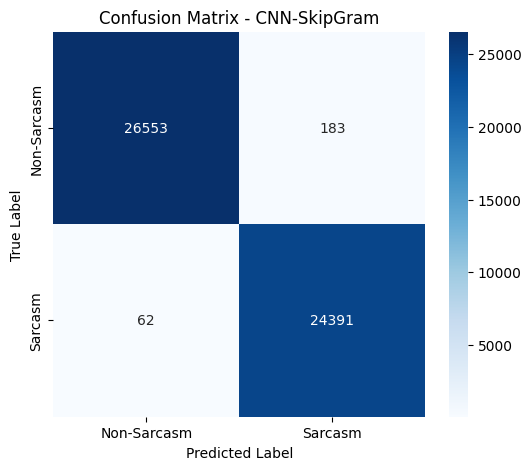


Classification Report for CNN-SkipGram:
               precision    recall  f1-score   support

Non-Sarcastic       1.00      0.99      1.00     26736
    Sarcastic       0.99      1.00      1.00     24453

     accuracy                           1.00     51189
    macro avg       1.00      1.00      1.00     51189
 weighted avg       1.00      1.00      1.00     51189



In [19]:
model = load_model("./model/model_cnn_skipgram_10.pth")
y_pred = predict(model, X_test_skipgram)

plot_confusion_matrix(y_true, y_pred, title=f"Confusion Matrix - CNN-SkipGram")
print(f"\nClassification Report for CNN-SkipGram:")
show_classification_report(y_true, y_pred)

In [13]:
model = load_model("./model/model_lstm_skipgram_10.pth")
y_pred = predict(model, X_test_skipgram)

plot_confusion_matrix(y_true, y_pred, title=f"Confusion Matrix - LSTM-SkipGram")
print(f"\nClassification Report for LSTM-SkipGram:")
show_classification_report(y_true, y_pred)

RuntimeError: [enforce fail at alloc_cpu.cpp:114] data. DefaultCPUAllocator: not enough memory: you tried to allocate 27719071160 bytes.

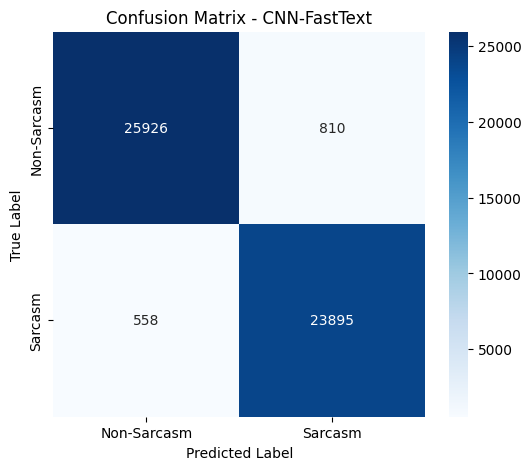


Classification Report for CNN-FastText:
               precision    recall  f1-score   support

Non-Sarcastic       0.98      0.97      0.97     26736
    Sarcastic       0.97      0.98      0.97     24453

     accuracy                           0.97     51189
    macro avg       0.97      0.97      0.97     51189
 weighted avg       0.97      0.97      0.97     51189



In [16]:
model = load_model("./model/model_cnn_fasttext_10.pth")
y_pred = predict(model, X_test_fasttext)

plot_confusion_matrix(y_true, y_pred, title=f"Confusion Matrix - CNN-FastText")
print(f"\nClassification Report for CNN-FastText:")
show_classification_report(y_true, y_pred)

In [17]:
model = load_model("./model/model_lstm_fasttext_10.pth")
y_pred = predict(model, X_test_fasttext)

plot_confusion_matrix(y_true, y_pred, title=f"Confusion Matrix - LSTM-FastText")
print(f"\nClassification Report for LSTM-FastText:")
show_classification_report(y_true, y_pred)

RuntimeError: [enforce fail at alloc_cpu.cpp:114] data. DefaultCPUAllocator: not enough memory: you tried to allocate 27719071160 bytes.

In [ ]:
# deprecated 
# needs too large memory for full dataset
for model_name, file_path in model_paths.items():
    model = load_model(file_path)
    if model_name.endswith("SkipGram"):
        X_test_tensor = X_test_skipgram
    elif model_name.endswith("FastText"):
        X_test_tensor = X_test_fasttext
    y_pred = predict(model, X_test_tensor)

    plot_confusion_matrix(y_true, y_pred, title=f"Confusion Matrix - {model_name}")
    print(f"\nClassification Report for {model_name}:")
    show_classification_report(y_true, y_pred)

See `predict.py` for predictions, where we split the test dataset

In [ ]:
%python predict.py

Comparison with Reference Paper

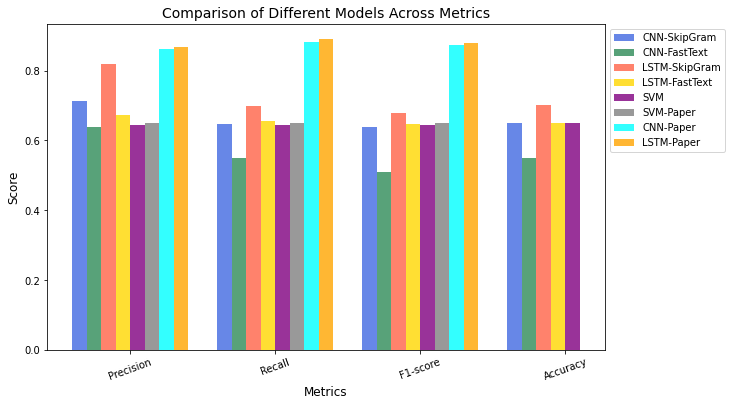

In [ ]:
model_names_C = [
    "CNN-SkipGram", "CNN-FastText", "LSTM-SkipGram", "LSTM-FastText",
    "SVM", "SVM-Paper", "CNN-Paper", "LSTM-Paper"
]


precision_values = [0.713, 0.638, 0.820, 0.674, 0.645, 0.65, 0.861, 0.868]
recall_values = [0.648, 0.549, 0.698, 0.654, 0.645, 0.65, 0.882, 0.89]
f1_values = [0.6395, 0.508, 0.6785, 0.648, 0.645, 0.65, 0.872, 0.879]
accuracy_values = [0.65, 0.55, 0.70, 0.65, 0.65, np.nan, np.nan, np.nan]

metrics = ["Precision", "Recall", "F1-score", "Accuracy"]
data_matrix = np.array([precision_values, recall_values, f1_values, accuracy_values]).T

x = np.arange(len(metrics))  
width = 0.1

colors = [
    "royalblue", "seagreen", "tomato", "gold",
    "purple", "gray", "cyan", "orange"
]

fig, ax = plt.subplots(figsize=(10, 6))

bars = []  
for i, (model, color) in enumerate(zip(model_names_C, colors)):
    values = data_matrix[i]
    bars.append(ax.bar(x + i * width, values, width, label=model, color=color, alpha=0.8))

ax.set_xlabel("Metrics", fontsize=12)
ax.set_ylabel("Score", fontsize=12)
ax.set_title("Comparison of Different Models Across Metrics", fontsize=14)
ax.set_xticks(x + (len(model_names_C) * width) / 2 - width / 2)
ax.set_xticklabels(metrics, fontsize=10)
ax.legend(bars, model_names_C, loc="upper left", bbox_to_anchor=(1, 1))

plt.xticks(rotation=20)
plt.show()